In [ ]:
import pandas as pd
import random
import torch
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Mounted at /content/gdrive


''

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/"

In [ ]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


# **Loading and Intergrating Data**

---


In [ ]:
df_biospec = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")

print(len(df_biospec))
print(len(df_biospec.columns))
df_biospec.head()

641
7


,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df_clinical = pd.read_csv(location + "clinical_masterDB.csv", sep=",")

df_clinical = df_clinical.drop(columns = ["ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS",
                                          "GENDER", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS",
                                          "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3", "MOCA","Unadjusted_MOCA", "TREMOR", "PIGD"],
                               axis = 1)

print(len(df_clinical))
print(len(df_clinical.columns))
df_clinical.head()

682
31


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,...,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,...,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,...,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,...,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,...,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
df_genetic = pd.read_csv(location + "snp_masterDB.csv", sep=",")

file = open(location + "Genetic/" + "feaSel_xgb_Genetic.txt", "r")
retain_list = []
counter = 0
for line in file:
  counter +=1
  if(counter > 0):
    retain_list.append(line[:-1])

retain_list = retain_list[:30]
print("features =", len(retain_list))

all_columns = df_genetic.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS" and i != "PATNO"):
    drop_list.append(i)

df_genetic = df_genetic.drop(columns = drop_list, axis = 1)
print(len(df_genetic))
print(len(df_genetic.columns))
df_genetic.head()

features = 30
733
32


,PATNO,chr4_90760828_C_T,chr4_90637010_A_G,chr4_90637601_G_A,chr4_90646886_G_A,chr4_90649290_C_G,chr4_90668614_T_C,chr4_90713064_G_A,chr4_90727088_C_T,chr4_90736006_A_C,...,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90713259_G_A,chr4_90635338_G_C,chr4_90638527_C_G,chr4_90645671_T_A,chr4_90682474_T_C,chr4_90695508_G_A,chr6_109004379_C_T,STATUS
0,3627,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,3214,0,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,3367,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df = pd.merge(df_clinical, df_biospec, on="PATNO")
df = pd.merge(df, df_genetic, on="PATNO")

print(len(df))
print(len(df.columns))
df.head()

598
68


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,...,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90713259_G_A,chr4_90635338_G_C,chr4_90638527_C_G,chr4_90645671_T_A,chr4_90682474_T_C,chr4_90695508_G_A,chr6_109004379_C_T,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,...,0,0,0,0,0,0,0,0,0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,...,0,0,0,0,0,0,0,0,0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,...,0,0,0,0,0,0,0,0,0,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,...,0,0,0,0,0,0,0,0,0,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.drop(columns = ["PATNO", "STATUS_x", "STATUS_y"], axis = 1)
df.head()

,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,HVLT_RECALL,...,chr4_90697979_T_C,chr4_90755239_G_A,chr4_90713259_G_A,chr4_90635338_G_C,chr4_90638527_C_G,chr4_90645671_T_A,chr4_90682474_T_C,chr4_90695508_G_A,chr6_109004379_C_T,STATUS
0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,28.125,...,0,0,0,0,0,0,0,0,0,0
1,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,26.875,...,0,0,0,0,0,0,0,0,0,1
2,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,25.875,...,0,0,0,0,0,0,0,0,0,1
3,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,26.125,...,0,0,0,0,0,0,0,0,0,1
4,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,21.000,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Early_Integration/"

# **XGBoost Feature Selection**

---

In [ ]:
print(len(df))
print(len(df.columns))

input_columns=len(df.columns)-1
output_columns=1

X = df.iloc[:, 0:input_columns]
y = df.iloc[:, -1]

598
65


46
First_Fam_PD          0.110251
UPSIT                 0.104768
SCOPA_GASTRO          0.084335
chr4_90727088_C_T     0.047895
chr4_90637010_A_G     0.041098
SCOPA_CARDIO          0.039364
SCOPA_THERMO          0.034595
RBDSQ                 0.029895
chr4_90760828_C_T     0.027935
chr4_90697979_T_C     0.025267
chr17_44102865_A_C    0.025008
T_TAU                 0.022576
Socio_Score           0.022487
chr4_90736006_A_C     0.021079
STAI                  0.020452
URATE                 0.019820
SFT                   0.019330
chr4_90697157_T_C     0.019077
chr4_90768889_T_A     0.017226
Other_Fam_PD          0.016996
HVLT_RECALL           0.016538
AGE                   0.015675
LNS                   0.015008
GDS                   0.015006
ABETA42               0.013994
SCOPA_PUPIL           0.012747
HVLT_RETENT           0.012563
ESS                   0.012069
A_SYN                 0.010775
SCOPA_TOTAL           0.010749
chr4_90649290_C_G     0.009984
BJLO                  0.009970
SCOPA

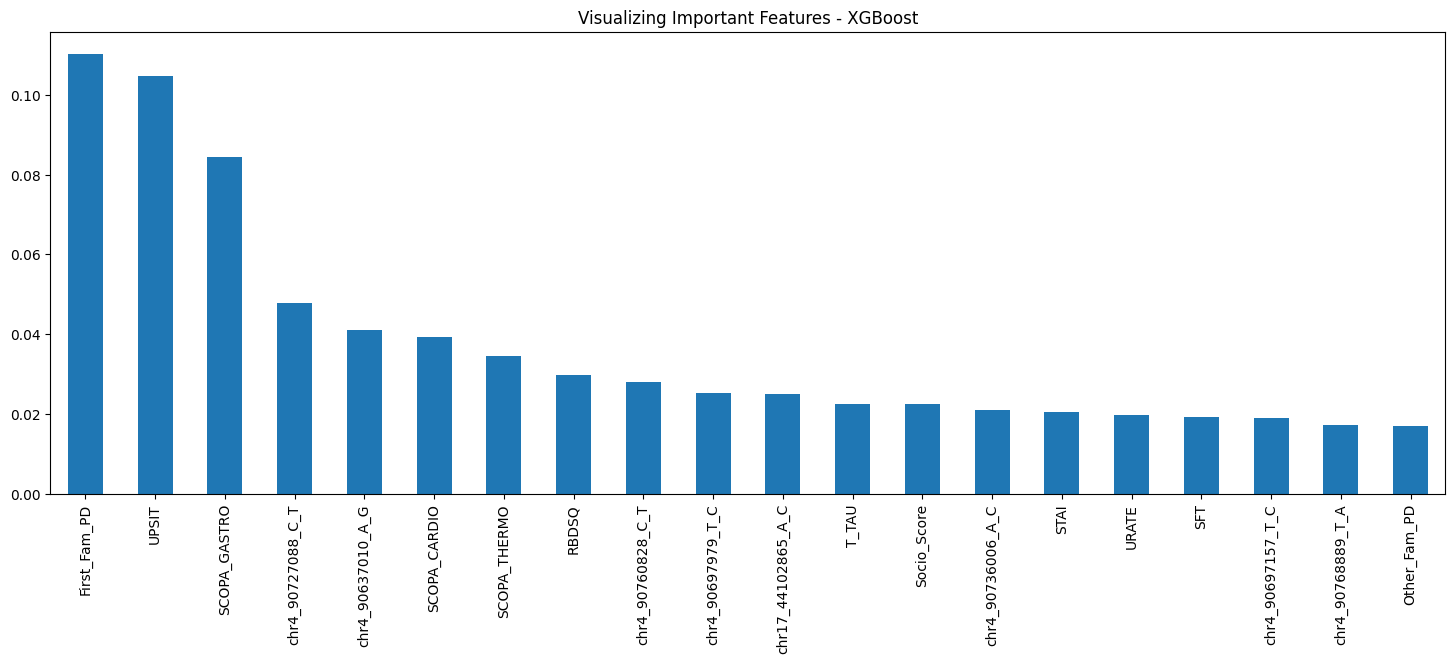

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

feature_imp = pd.Series(xgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(len(feature_imp[feature_imp>0]))
print(feature_imp[feature_imp>0])

(feature_imp.sort_values(ascending=False).head(20)).plot(kind = 'bar', figsize = (18,6))
plt.title("Visualizing Important Features - XGBoost")
plt.show()

feaSel_xgb = list(feature_imp[feature_imp>0].index)

In [ ]:
# temp = feature_imp.sort_values(ascending=False).head(20)

# score = temp.values
# x = temp.index


# c = "tab:green"
# b = "tab:blue"
# g = "tab:orange"
# colors_list = list([c,c,g,g,c,c,g,g,c,c,g,c,g,b,g,c,b,b,b,b])

# plt.figure(figsize=(18,6))
# plt.bar(x, score, color=colors_list)
# plt.xticks(rotation = 90)
# plt.title("Visualizing Important Features - XGBoost")
# plt.show()

# **ML Models**

---


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
print(len(df))
print(len(df.columns))

input_columns = len(df.columns)-1
output_columns = 1

598
65


In [ ]:
path = location + "shuffled_df_early.csv"
df.to_csv(path, index=False)

In [ ]:
train_length = int(0.8*len(df))
test_length = int(0.2*len(df))+1
print(train_length, test_length)

478 120


In [ ]:
# dataset = df.values
X = df.iloc[:train_length,0:input_columns]
y = df.iloc[:train_length, -1]

X_test = df.iloc[train_length: (train_length + test_length), 0:input_columns]
y_test = df.iloc[train_length: (train_length + test_length), -1]

In [ ]:
train_data_file = location + 'train_data.pkl'
test_data_file = location + 'test_data.pkl'

# Save training data
with open(train_data_file, 'wb') as f:
    pickle.dump((X, y), f)

# Save test data
with open(test_data_file, 'wb') as f:
    pickle.dump((X_test, y_test), f)

'/content/gdrive/My Drive/MultiModal_PD/Early_Integration/train_data.pkl'

Train Data distribtuion:
STATUS
PD    340
HC    138
Name: count, dtype: int64


<Axes: title={'center': 'Train Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

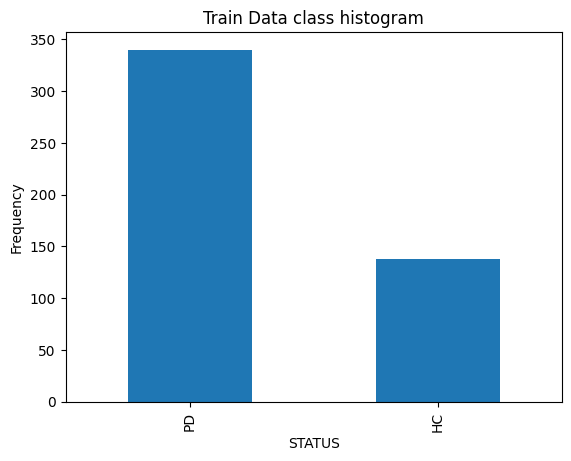

In [ ]:
# Train data distribution
count_classes = y.replace({0:"HC", 1:"PD"}).value_counts()
print("Train Data distribtuion:")
print(count_classes)
plt.title("Train Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

Test Data distribtuion:
STATUS
PD    87
HC    33
Name: count, dtype: int64


<Axes: title={'center': 'Test Data class histogram'}, xlabel='STATUS', ylabel='Frequency'>

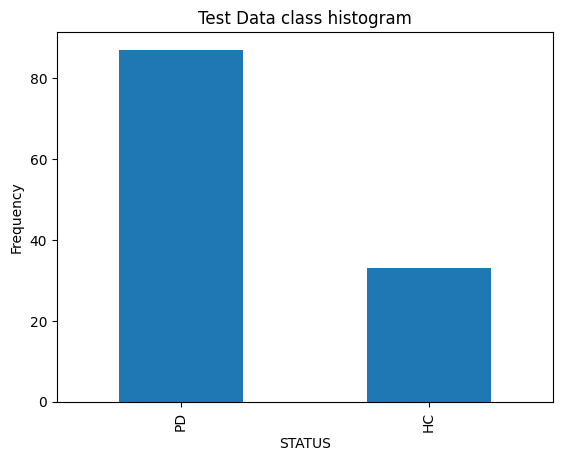

In [ ]:
# Test data distribution
count_classes = y_test.replace({0:"HC", 1:"PD"}).value_counts()
print("Test Data distribtuion:")
print(count_classes)
plt.title("Test Data class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
count_classes.plot(kind = 'bar')

In [ ]:
scalarX = MinMaxScaler() # Normalising
scalarX.fit(X)

X = scalarX.transform(X)
X_test = scalarX.transform(X_test)

## **Random Forest**

---

In [ ]:
clf = RandomForestClassifier()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

#Setting the range for class weights
weights = np.linspace(0.8,0.99, 50)


# specify parameters and distributions to sample from
hp = {
    'bootstrap': [True, False],
      'criterion': ['gini', 'entropy'],
      'n_estimators': [10, 25],
      'max_features': [5, 10],
      'max_depth': [10, 50, None],
      'max_depth': np.arange(1, 40, 1),
      'max_features': ['auto', 'sqrt', 'log2', 5, 10, 12, 15, 17, 18, 20, 23, 25],
      'min_samples_leaf': [0, 1, 2, 3, 4, 5],
      'min_samples_split': [1, 2, 5, 10],
      'n_estimators': np.arange(150, 300, 50),
      'warm_start': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_RF' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
330 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
165 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

RandomForestClassifier(class_weight={0: 0.9861224489795919,
                                     1: 0.013877551020408108},
                       criterion='entropy', max_depth=19, max_features=23,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=250, warm_start=True)
{'bootstrap': True,
 'class_weight': {0: 0.9861224489795919, 1: 0.013877551020408108},
 'criterion': 'entropy',
 'max_depth': 19,
 'max_features': 23,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 250,
 'warm_start': True}

Saving model



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


AUC-ROC =  0.9230233368164403
AUC-PR =  0.970537160322785
F1 score =  0.9047619047619048
Precision =  0.9382716049382716
Recall =  0.8735632183908046
              precision    recall  f1-score   support

           0       0.72      0.85      0.78        33
           1       0.94      0.87      0.90        87

    accuracy                           0.87       120
   macro avg       0.83      0.86      0.84       120
weighted avg       0.88      0.87      0.87       120



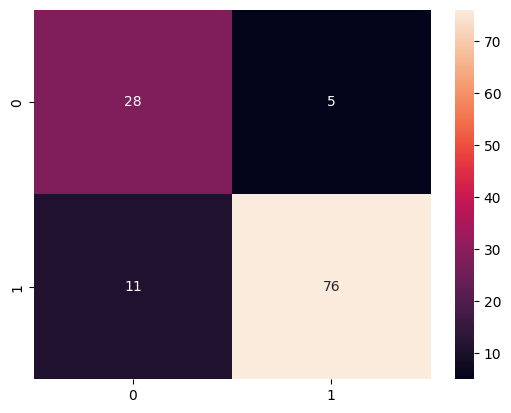

In [ ]:
# load the model from disk
filename = location + 'early_RF' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_rf = clf


y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

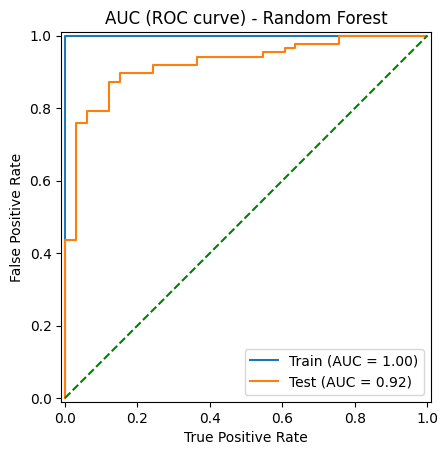

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
     RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Random Forest")
plt.show()

## **Gaussian Naive Bayes**

---

In [ ]:
clf = GaussianNB()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'var_smoothing': np.logspace(0,-9, num=100)}
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 200
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_GNB' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 100 is smaller than n_iter=200. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


GaussianNB(var_smoothing=1.0)
{'var_smoothing': 1.0}

Saving model



AUC-ROC =  0.8679902473005922
AUC-PR =  0.948461275971954
F1 score =  0.8375
Precision =  0.9178082191780822
Recall =  0.7701149425287356
              precision    recall  f1-score   support

           0       0.57      0.82      0.68        33
           1       0.92      0.77      0.84        87

    accuracy                           0.78       120
   macro avg       0.75      0.79      0.76       120
weighted avg       0.82      0.78      0.79       120



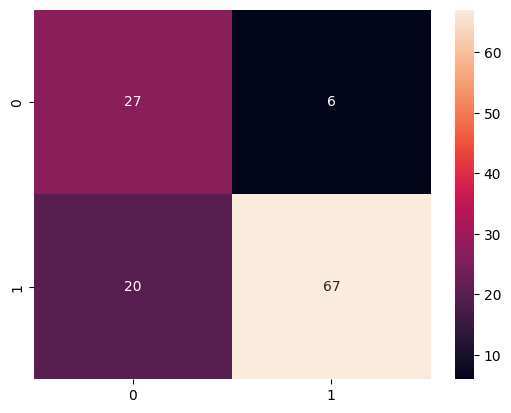

In [ ]:
# load the model from disk
filename = location + 'early_GNB' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_gnb = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

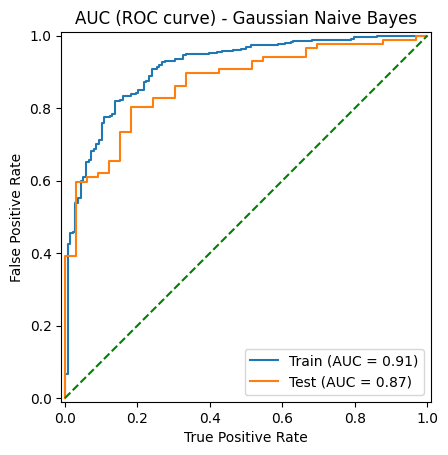

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

for i in range(2):
     RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Gaussian Naive Bayes")
plt.show()

## **SVM**

---

In [ ]:
clf = SVC(probability=True, random_state=42)

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
      'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
      'gamma': ['scale', 'auto'],
      'shrinking': [True, False],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'decision_function_shape': ['ovo', 'ovr']
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 150
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='balanced_accuracy',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_SVM' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 150 candidates, totalling 750 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

SVC(C=40, class_weight={0: 0.7273469387755102, 1: 0.27265306122448985},
    decision_function_shape='ovo', gamma='auto', kernel='sigmoid',
    probability=True, random_state=42)
{'C': 40,
 'class_weight': {0: 0.7273469387755102, 1: 0.27265306122448985},
 'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'sigmoid',
 'shrinking': True}

Saving model



AUC-ROC =  0.8719958202716824
AUC-PR =  0.9592432950191572
F1 score =  0.8805031446540881
Precision =  0.9722222222222222
Recall =  0.8045977011494253
              precision    recall  f1-score   support

           0       0.65      0.94      0.77        33
           1       0.97      0.80      0.88        87

    accuracy                           0.84       120
   macro avg       0.81      0.87      0.82       120
weighted avg       0.88      0.84      0.85       120



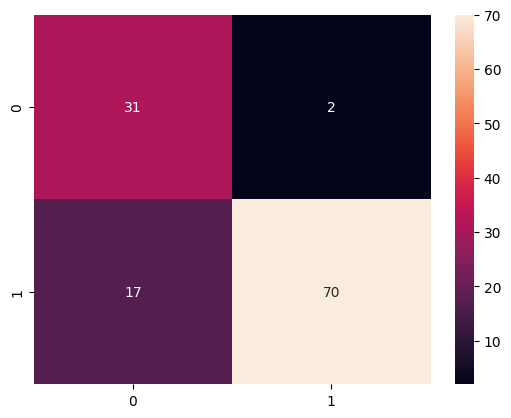

In [ ]:
# load the model from disk
filename = location + 'early_SVM' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_svm = clf

y_pred = clf.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)
print("AUC-ROC = ", auc(fpr,tpr))
prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
print("AUC-PR = ", auc(rec, prec))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

SVC(C=40, class_weight={0: 0.7273469387755102, 1: 0.27265306122448985},
    decision_function_shape='ovo', gamma='auto', kernel='sigmoid',
    probability=True, random_state=42)


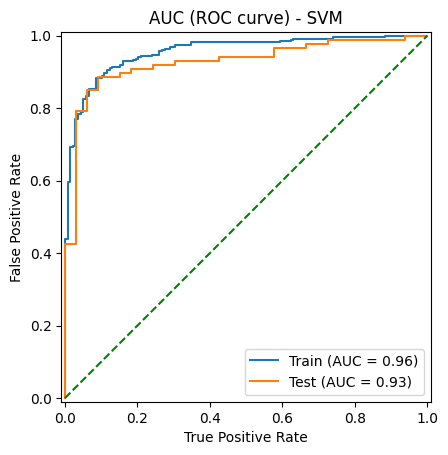

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
   RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - SVM")
plt.show()

## **Logistic Regression**

---

In [ ]:
clf = LogisticRegression()

# # Parameters used by our current forest
# print('Parameters initial\n')
# pprint(clf.get_params())

# specify parameters and distributions to sample from
hp = {'C': [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 25, 50, 75, 100],
      'penalty': ['l1', 'l2', 'elasticnet'],
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'class_weight': [{0:x, 1:1.0-x} for x in weights],
      'multi_class': ['multinomial', 'ovr', 'auto'],
      'warm_start': [True, False],
      'l1_ratio': np.arange(0, 1.1, 0.1),
      'random_state': [81]
      }
# pprint(hp)

# run randomized search
print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                    param_distributions=hp,
                                    n_iter=n_iter_search,
                                    cv=StratifiedKFold(),
                                    verbose = 5,
                                    scoring='roc_auc',
                                    return_train_score = True,
                                    n_jobs = n_jobs_val)

#Train the model using the training sets y_pred=clf.predict(X_test)
random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X,y)

# save the model to disk
filename = location + 'early_logReg' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
4200 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
695 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

LogisticRegression(C=10,
                   class_weight={0: 0.9512244897959183, 1: 0.04877551020408166},
                   l1_ratio=0.30000000000000004, multi_class='ovr',
                   penalty='l1', random_state=81, solver='liblinear',
                   warm_start=True)
{'C': 10,
 'class_weight': {0: 0.9512244897959183, 1: 0.04877551020408166},
 'l1_ratio': 0.30000000000000004,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 81,
 'solver': 'liblinear',
 'warm_start': True}

Saving model



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5        ... 0.90717009 0.9077381         nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the train scores are non-finite: [       nan        nan 0.5        ... 0.96999753 0.96729399        nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_m

AUC-ROC =  0.940090560780216
AUC-PR =  0.9785950948405701
F1 score =  0.7832167832167832
Precision =  1.0
Recall =  0.6436781609195402
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        33
           1       1.00      0.64      0.78        87

    accuracy                           0.74       120
   macro avg       0.76      0.82      0.73       120
weighted avg       0.87      0.74      0.75       120



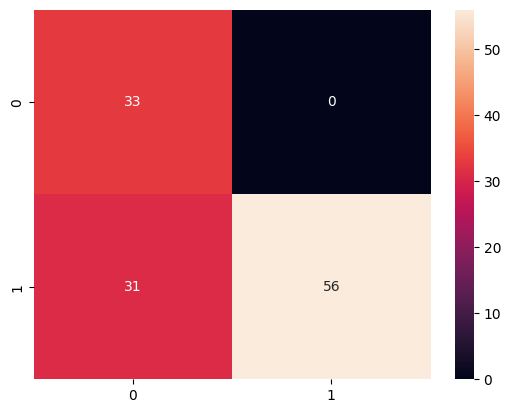

In [ ]:
# load the model from disk
filename = location + 'early_logReg' + '.sav'
clf = pickle.load(open(filename, 'rb'))
clf_logReg = clf

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:,1]

print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Ploting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()

LogisticRegression(C=10,
                   class_weight={0: 0.9512244897959183, 1: 0.04877551020408166},
                   l1_ratio=0.30000000000000004, multi_class='ovr',
                   penalty='l1', random_state=81, solver='liblinear',
                   warm_start=True)


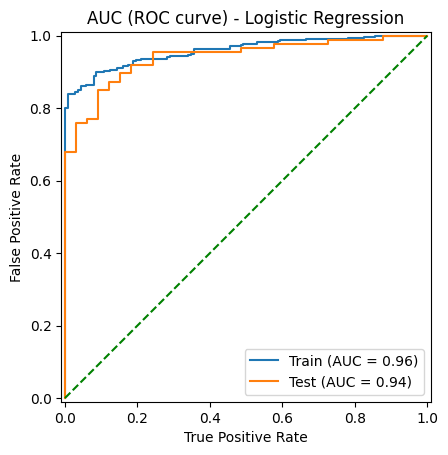

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf)

for i in range(2):
   RocCurveDisplay.from_estimator(clf, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve) - Logistic Regression")
plt.show()

## **LightGBM**

---

In [ ]:
clf = LGBMClassifier()

# # Parameters used by our current model
# print('Parameters initial\n')
# pprint(clf.get_params())

# Setting the range for class weights
weights = np.linspace(0.6, 0.99, 50)

# Specify parameters and distributions to sample from
hp = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': np.arange(50, 500, 50),
    'min_child_samples': np.arange(20, 200, 20),
    'subsample': np.linspace(0.5, 1, 10),
    'colsample_bytree': np.linspace(0.5, 1, 10),
    'reg_alpha': np.logspace(-4, 1, 20),
    'reg_lambda': np.logspace(-4, 1, 20),
    'class_weight': [{0: x, 1: 1.0 - x} for x in weights]
}

# # Print the parameter space
# pprint(hp)

# Run randomized search
print("\nStarting randomized search\n")
n_iter_search = 250
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(),
                                   verbose=2,
                                   scoring='roc_auc',
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model using the training sets
random_search.fit(X, y)

# Display the best model and its parameters
pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

# Save the best estimator
clf = random_search.best_estimator_

clf.fit(X, y)

filename = location + 'early_lgbm' + '.sav'
pickle.dump(clf, open(filename, 'wb'))



Starting randomized search

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[LightGBM] [Info] Number of positive: 340, number of negative: 138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2772
[LightGBM] [Info] Number of data points in the train set: 478, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499840 -> initscore=-0.000641
[LightGBM] [Info] Start training from score -0.000641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:

# Define the file paths
train_data_file = location + 'train_data.pkl'
test_data_file = location + 'test_data.pkl'

# Load training data
with open(train_data_file, 'rb') as f:
    X, y = pickle.load(f)

# Load test data
with open(test_data_file, 'rb') as f:
    X_test, y_test = pickle.load(f)

AUC-ROC =  0.7070707070707071
AUC-PR =  0.8427147484086701
F1 score =  0.8404255319148937
Precision =  0.7821782178217822
Recall =  0.9080459770114943
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        33
           1       0.78      0.91      0.84        87

    accuracy                           0.75       120
   macro avg       0.68      0.62      0.63       120
weighted avg       0.73      0.75      0.73       120



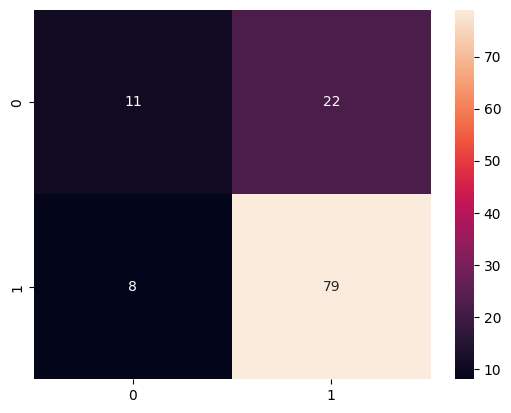

In [ ]:
# Load the model from disk
filename = location + 'early_lgbm' + '.sav'
clf_lgbm = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_lgbm.predict(X_test)
y_pred_proba = clf_lgbm.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix - LightGBM")
plt.show()


LGBMClassifier(class_weight={0: 0.7114285714285714, 1: 0.2885714285714286},
               colsample_bytree=0.7222222222222222,
               learning_rate=0.27999999999999997, max_depth=4, num_leaves=40,
               reg_alpha=1.623776739188721, reg_lambda=0.07847599703514607,
               subsample=0.8333333333333333)


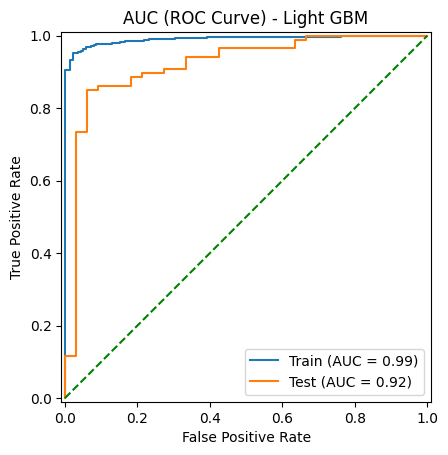

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_lgbm)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_lgbm, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Light GBM")
plt.show()

## **NN**

---

In [ ]:
clf = MLPClassifier(max_iter=200, random_state=42)

param_dist = {
    'hidden_layer_sizes': [(np.random.randint(50, 200),) * np.random.randint(1, 4) for _ in range(10)],  # Randomly select layer sizes and depths
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-5, 3, num=8),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': np.logspace(-4, 0, num=5),
    'batch_size': [32, 64, 128, 256],
    'early_stopping': [True],
    'n_iter_no_change': [5, 10, 15],
    'momentum': np.linspace(0.5, 0.95, num=5),
}


print("\nStarting randomized search\n")
n_iter_search = 1500
n_jobs_val = -1
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=StratifiedKFold(),
    verbose=5,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=n_jobs_val,
    random_state=42
)

random_search.fit(X,y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving model\n")

clf = random_search.best_estimator_

clf.fit(X,y)

# Save the best model to disk

print("\nSaving model\n")

filename = location + 'early_mlp' + '.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 751, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/l

MLPClassifier(activation='tanh', alpha=0.00013894954943731373, batch_size=64,
              early_stopping=True, hidden_layer_sizes=(87, 87, 87),
              learning_rate='invscaling', momentum=0.8374999999999999,
              n_iter_no_change=15, random_state=42)
{'activation': 'tanh',
 'alpha': 0.00013894954943731373,
 'batch_size': 64,
 'early_stopping': True,
 'hidden_layer_sizes': (87, 87, 87),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'momentum': 0.8374999999999999,
 'n_iter_no_change': 15,
 'solver': 'adam'}

Saving model


Saving model



AUC-ROC =  0.928944618599791
AUC-PR =  0.9713340794418365
F1 score =  0.8944099378881988
Precision =  0.972972972972973
Recall =  0.8275862068965517
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        33
           1       0.97      0.83      0.89        87

    accuracy                           0.86       120
   macro avg       0.82      0.88      0.84       120
weighted avg       0.89      0.86      0.86       120



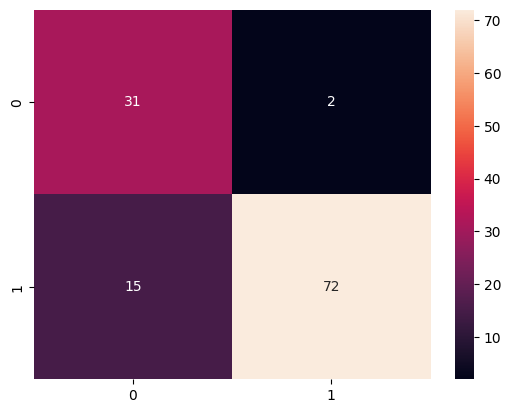

In [ ]:
# Load the model from disk
filename = location + 'early_mlp' + '.sav'
clf_mlp = pickle.load(open(filename, 'rb'))

# Predictions and evaluation
y_pred = clf_mlp.predict(X_test)
y_pred_proba = clf_mlp.predict_proba(X_test)[:, 1]

# Display metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.show()


MLPClassifier(activation='tanh', alpha=0.00013894954943731373, batch_size=64,
              early_stopping=True, hidden_layer_sizes=(87, 87, 87),
              learning_rate='invscaling', momentum=0.8374999999999999,
              n_iter_no_change=15, random_state=42)


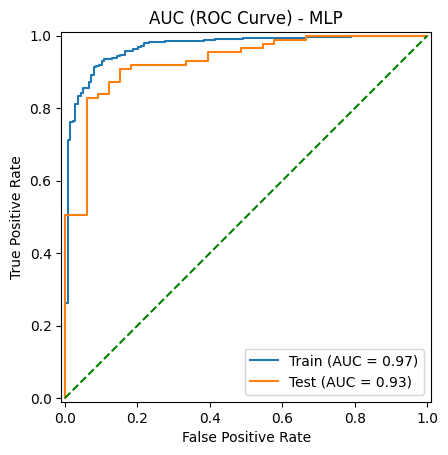

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_mlp)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_mlp, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - MLP")
plt.show()

# **Training the Ensemble Model**

---



In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    f1_neg = f1_score(y_true, y_pred, pos_label=0)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    return (f1_neg + f1_pos) / 2

custom_scorer = make_scorer(custom_scorer)

In [ ]:
clf_rf = pickle.load(open(location + 'early_RF.sav', 'rb'))
clf_gnb = pickle.load(open(location + 'early_GNB.sav', 'rb'))
clf_svm = pickle.load(open(location + 'early_SVM.sav', 'rb'))
clf_logReg = pickle.load(open(location + 'early_logReg.sav', 'rb'))
clf_lgbm = pickle.load(open(location + 'early_lgbm.sav', 'rb'))
clf_mlp = pickle.load(open(location + 'early_mlp.sav', 'rb'))

In [ ]:
clf = VotingClassifier(
    estimators=[
        ('rf', clf_rf),
        ('gnb', clf_gnb),
        ('svm', clf_svm),
        ('logReg', clf_logReg),
        ('lgbm', clf_lgbm),
        ('mlp', clf_mlp)
    ],
    voting='soft'
)

hp = {
    'voting': ['hard', 'soft'],
    'flatten_transform': [True, False]
}

# Run randomized search
print("\nStarting randomized search for Ensemble\n")
n_iter_search = 100
n_jobs_val = -1
random_search = RandomizedSearchCV(clf,
                                   param_distributions=hp,
                                   n_iter=n_iter_search,
                                   cv=StratifiedKFold(),
                                   verbose=5,
                                   scoring=custom_scorer,
                                   return_train_score=True,
                                   n_jobs=n_jobs_val)

# Train the model
random_search.fit(X, y)

pprint(random_search.best_estimator_)
pprint(random_search.best_params_)
pd.DataFrame(random_search.cv_results_)

print("\nSaving ensemble model\n")

clf = random_search.best_estimator_

# Train the model using the entire dataset
clf.fit(X, y)

# Save the model to disk
filename = location + 'early_Ensemble.sav'
pickle.dump(clf, open(filename, 'wb'))


Starting randomized search for Ensemble

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 340, number of negative: 138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2772
[LightGBM] [Info] Number of data points in the train set: 478, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499840 -> initscore=-0.000641
[LightGBM] [Info] Start training from score -0.000641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 340, number of negative: 138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2772
[LightGBM] [Info] Number of data points in the train set: 478, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499840 -> initscore=-0.000641
[LightGBM] [Info] Start training from score -0.000641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

AUC-ROC =  0.9418321142459074
AUC-PR =  0.9784236429357289
F1 score =  0.8875
Precision =  0.9726027397260274
Recall =  0.8160919540229885
              precision    recall  f1-score   support

           0       0.66      0.94      0.78        33
           1       0.97      0.82      0.89        87

    accuracy                           0.85       120
   macro avg       0.82      0.88      0.83       120
weighted avg       0.89      0.85      0.86       120



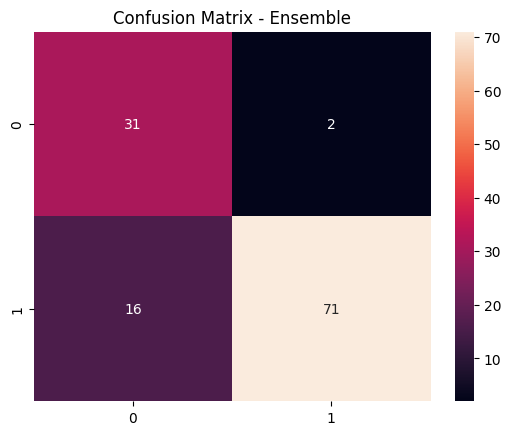

In [ ]:
# Load the model from disk
filename = location + 'early_Ensemble.sav'
clf_ensemble = pickle.load(open(filename, 'rb'))

# Make predictions
y_pred = clf_ensemble.predict(X_test)
y_pred_proba = clf_ensemble.predict_proba(X_test)[:, 1]

# Print performance metrics
print("AUC-ROC = ", roc_auc_score(y_test, y_pred_proba))
print("AUC-PR = ", average_precision_score(y_test, y_pred_proba))
print("F1 score = ", f1_score(y_test, y_pred))
print("Precision = ", precision_score(y_test, y_pred))
print("Recall = ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix - Ensemble")
plt.show()


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={0: 0.9861224489795919,
                                                                   1: 0.013877551020408108},
                                                     criterion='entropy',
                                                     max_depth=19,
                                                     max_features=23,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=250,
                                                     warm_start=True)),
                             ('gnb', GaussianNB(var_smoothing=1.0)),
                             ('svm',
                              SVC(C=40,
                                  class_weight={0: 0.7273469387755102,
                                                1: 0.2726530612

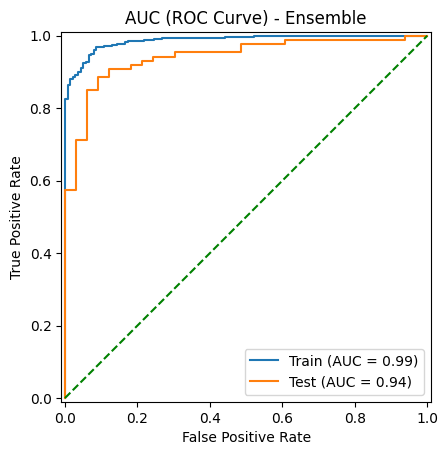

In [ ]:
ax = plt.gca()
X_list = [X, X_test]
y_list = [y, y_test]
name_list = ["Train", "Test"]

print(clf_ensemble)

for i in range(2):
    RocCurveDisplay.from_estimator(clf_ensemble, X_list[i], y_list[i], name=name_list[i], ax=ax)
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Ensemble")
plt.show()

## **ROC Curve**

---

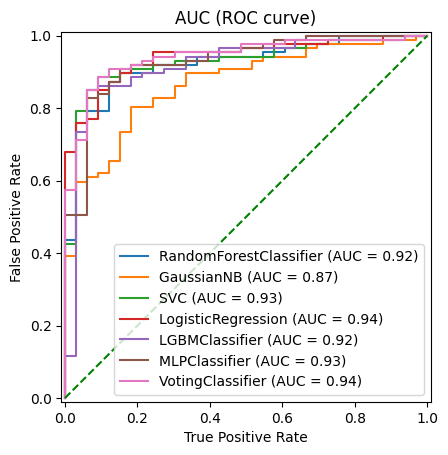

In [ ]:
ax = plt.gca()
classifiers = [clf_rf, clf_gnb, clf_svm, clf_logReg, clf_lgbm, clf_mlp, clf_ensemble]

for i in classifiers:
    RocCurveDisplay.from_estimator(i, X_test, y_test, ax=ax)
# plt.plot(fpr_test, tpr_test, label='ANN (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC (ROC curve)")
plt.show()